## Import Packages

All packages that are needed are imported in the next cell, should only be ran once. 

In [1]:
import sys
!{sys.executable} -m pip install rouge

In [2]:
import gzip as gz
import json
import sys as sklearn
import spacy as sp
import pandas as pd
import numpy as np
import re
import networkx as nx
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.cluster.util import cosine_distance
from rouge import Rouge

## Load Data

In [3]:
path = "newsroom-release/release/dev.jsonl.gz"
data = []

with gz.open(path) as f:
    for ln in f:
        obj = json.loads(ln)
        data.append(obj)

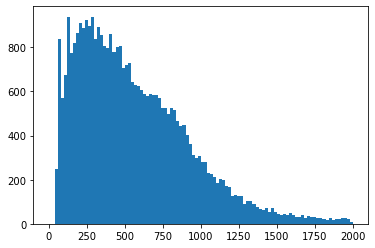

In [4]:
# Extracting appropriate data and transforming to pandas dataframe
df = pd.DataFrame(data)
df_extractive = df[df.density_bin == 'extractive']

# Filtering on rough estimate of lenght text
article_lengths = [len(text.split()) for text in df_extractive.text]
_ = plt.hist(article_lengths, bins = 100, range = (0, 2000))
length_check = [len > 250 for len in article_lengths]
df_extractive = df_extractive[length_check]

## Intermidiate Input Representation

### Sentence splitting

In [7]:
nlp = sp.load("en_core_web_sm", disable=["tagger", "parser", "ner", "textcat"])
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [8]:
# SENTENCE SPLITTING FUNCTION
def sentence_splitting(doc):
    # Using the NLP sentencizer pipeline to extract all text sentences
    doc = nlp(doc['text'])
    sentences = [sent.string.strip() for sent in doc.sents]
    
    return sentences

### Sparse TF-ISF matrix representation

In [9]:
# PREPROCESSING FUNCTION
def preprocess(text):
    # Transform text with SpaCy model for NLP procedures
    text = nlp(text)
    
    # loop through the words in the text, removing stopwords and numerics
    # Assign the remaining tokens to the token list in the lemma form
    tokens = []
    for token in text:
        if token.is_stop == False and token.is_alpha == True:
            tokens.append(token.lemma_)
    
    return tokens

In [10]:
# TF-ISF MATRIX CREATION FUNCTION
def create_tfisf_matrix(sentences, preprocessor = preprocess):
    #Initializing ScikitLearn TF-IDF vectorizer and creating TF-IDF sparse matrix
    vectorizer = TfidfVectorizer(tokenizer = preprocessor)
    tfisf_matrix = vectorizer.fit_transform(sentences)
    
    # Saving list of all corpus tokens
    feature_names = vectorizer.get_feature_names()

    # Returning TF-IDF matrix
    return tfisf_matrix, feature_names

## Similarity matrix 

In [11]:
# SIMILARITY MATRIX FUNCTIUON
def create_sim_matrix(sentences, tfisf_matrix):
    # Remove possible NaN or inf or -inf and replace with numerical value
    tfisf_matrix = np.nan_to_num(tfisf_matrix)
    
    # Transform matrix to list representation, needed for the cosine distance function
    tfisf_matrix_list = tfisf_matrix.toarray().tolist()
    
    # Initialize empty quadratic sentence similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
    
    # Loop over all similarity matrix positions, calculating the cosine similarity sentence i,j
    for i in range(len(sentences)):
        # Ignore if sentence has no token, avoids cosine distance calculation of zero-vector
        if sum(tfisf_matrix_list[i]) == 0:
            continue
        for j in range(len(sentences)):
            # Ignore if both are same sentences or sentence has no token
            if i == j or sum(tfisf_matrix_list[j]) == 0: 
                continue 
            similarity_matrix[i][j] = 1 - cosine_distance(tfisf_matrix_list[i], tfisf_matrix_list[j])
    
    # Return the final similarity matrix
    return similarity_matrix


## Graph representation and sentence scoring

In [12]:
# SENTENCE SCORING FUNCTION
def textrank_sentence_scoring(similarity_matrix, sentences):
    # Create graphical representation from similarity matrix
    graph = nx.from_numpy_array(similarity_matrix)
    
    # Rank all sentences according to pagerank algorithm
    sentence_scores = nx.pagerank(graph, max_iter = 500)
    
    # Sort all sentences and sentence index according to score
    sentence_scores_sorted = sorted(((sentence_scores[i],i) for i,s in enumerate(sentences)), reverse=True)    
    
    # Return the sorted sentence scores + index 
    return sentence_scores_sorted

## Sentence Extraction

In [13]:
def textrank_sentence_extraction(sentences, sentence_scores, n):
    summary = []
    
    # Sort sentence indices in ascending order
    sentence_indices_sorted = sorted(sentence_scores[0:n], key=lambda tup: tup[1])
    
    # Extract sentences and append to summary in that order
    for i in sentence_indices_sorted:
        summary.append(sentences[i[1]])
    
    # Join all sentences to form final summary
    summary = ' '.join(summary)
    
    # Return summary
    return summary
    

 # Running the Model


In [20]:
# Setting corpus size to evaluate
corpus = df_extractive.sample(5000)
corpus.reset_index(inplace = True)
summaries = []

# Looping over every document in every corpus, running each model step
for index, doc in corpus.iterrows():
    # Sentence split document
    sentences = sentence_splitting(doc)
    
    # TF-ISF matrix construction
    tfisf_matrix, feature_names = create_tfisf_matrix(sentences = sentences)
    
    # Similarity matrix construction
    similarity_matrix = create_sim_matrix(sentences, tfisf_matrix)
    
    # Scoring each document sentence
    sentence_scores = textrank_sentence_scoring(similarity_matrix, sentences)
    
    # Extracting and merging sentences 
    summary = textrank_sentence_extraction(sentences, sentence_scores, 3)
    
    # Append summary to list of summaries 
    summaries.append(summary)
    
    # Checkpoint alert
    if index != 0 and index % 5000 == 0:
        print('Checkpoint: ', index)


# Score summaries with ROUGE

In [21]:
# ROUGE AND BLEU SCORING FUNCTION
def rouge_blue_scoring(summary, reference):
    rouge_score = rouge.get_scores(summary, reference)
    
    return rouge_score

In [22]:
rouge = Rouge()
scores = rouge_blue_scoring(summaries, corpus.iloc[0:len(summaries)].summary.values.tolist())
scores_pd = pd.DataFrame(scores)

rouge1_f1_scores = []
rouge1_recall_scores = []
rouge1_precision_scores = []

rouge2_f1_scores = []
rouge2_recall_scores = []
rouge2_precision_scores = []

rougel_f1_scores = []
rougel_recall_scores = []
rougel_precision_scores = []

for i, score in scores_pd.iterrows():
    rouge1_f1_scores.append(score['rouge-1']['f'])
    rouge1_recall_scores.append(score['rouge-1']['r'])
    rouge1_precision_scores.append(score['rouge-1']['p'])
    
    rouge2_f1_scores.append(score['rouge-2']['f'])
    rouge2_recall_scores.append(score['rouge-2']['r'])
    rouge2_precision_scores.append(score['rouge-2']['p'])
    
    rougel_f1_scores.append(score['rouge-l']['f'])
    rougel_recall_scores.append(score['rouge-l']['r'])
    rougel_precision_scores.append(score['rouge-l']['p'])
    
rouge1_f1_average = sum(rouge1_f1_scores)/len(rouge1_f1_scores)
rouge1_recall_average = sum(rouge1_recall_scores)/len(rouge1_recall_scores)
rouge1_precision_average = sum(rouge1_precision_scores)/len(rouge1_precision_scores)

rouge2_f1_average = sum(rouge2_f1_scores)/len(rouge2_f1_scores)
rouge2_recall_average = sum(rouge2_recall_scores)/len(rouge2_recall_scores)
rouge2_precision_average = sum(rouge2_precision_scores)/len(rouge2_precision_scores)

rougel_f1_average = sum(rougel_f1_scores)/len(rougel_f1_scores)
rougel_recall_average = sum(rougel_recall_scores)/len(rougel_recall_scores)
rougel_precision_average = sum(rougel_precision_scores)/len(rougel_precision_scores)


res = {'r1': {'r': rouge1_recall_average, 'p': rouge1_precision_average, 'f1': rouge1_f1_average},
      'r2': {'r': rouge2_recall_average, 'p': rouge2_precision_average, 'f1': rouge2_f1_average},
      'rl': {'r': rougel_recall_average, 'p': rougel_precision_average, 'f1': rougel_f1_average}}

pd.DataFrame(res).to_csv('TextRank_res.csv')